In [41]:
import numpy as np
import pandas as pd
import sys
import pickle
import os
import time as tm
from functools import partial
import scipy.stats as st
from scipy.stats import wasserstein_distance
import scipy.stats
import copy
from sklearn.model_selection import KFold
import pandas as pd
import multiprocessing
import matplotlib as mpl 
import matplotlib.pyplot as plt
import scanpy as sc
import warnings
import subprocess
warnings.filterwarnings('ignore')

#SpaOTsc
from spaotsc import SpaOTsc
from scipy.spatial import distance_matrix
from sklearn.metrics import matthews_corrcoef
from scipy import stats

#novoSpaRc
import novosparc as nc
from scipy.spatial.distance import cdist
import h5py

# add Tangram to path
import anndata
import torch
import sys

sys.path.append("Tangram-master") 
import mapping.utils
import mapping.mapping_optimizer
import mapping.plot_utils

class MappingCell:
    def __init__(self, RNA_path, Spatial_path, location_path, count_path = None, device = 'CPU', scrna_meta = None, gd_result = None, outdir = None):
        self.RNA_path = RNA_path
        self.Spatial_path = Spatial_path
        self.RNA_data =  pd.read_csv(RNA_path, sep='\t', index_col = 0)
        self.Spatial_data = pd.read_csv(Spatial_path, sep='\t', header=0)
        self.locations = np.loadtxt(location_path, skiprows=1)
        self.device = device
        if count_path != None:
            self.count =pd.read_csv(count_path,sep='\t', index_col = 0).astype(int)
        self.scrna_meta = scrna_meta
        self.gd =  pd.read_csv(gd_result, sep='\t', index_col = 0)
        self.outdir = outdir

    def novoSpaRc(self):
        gene_names = self.RNA_data.index.values
        dge = self.RNA_data.values
        dge = dge.T
        num_cells = dge.shape[0]
        print ('number of cells and genes in the matrix:', dge.shape)
    
        hvg = np.argsort(np.divide(np.var(dge,axis=0),np.mean(dge,axis=0)+0.0001))
        dge_hvg = dge[:,hvg[-2000:]]
        
        num_locations = self.locations.shape[0]
    
        p_location, p_expression = nc.rc.create_space_distributions(num_locations, num_cells)
        cost_expression, cost_locations = nc.rc.setup_for_OT_reconstruction(dge_hvg,self.locations,num_neighbors_source = 5,num_neighbors_target = 5)
        
        insitu_genes = self.Spatial_data.columns & gene_names
        insitu_matrix = self.Spatial_data.loc[:,insitu_genes]
        
        markers_in_sc = np.array([], dtype='int')
        for marker in insitu_genes:
            marker_index = np.where(gene_names == marker)[0]
            if len(marker_index) > 0:
                markers_in_sc = np.append(markers_in_sc, marker_index[0])
        print (len(markers_in_sc))
        
        cost_marker_genes = cdist(dge[:, markers_in_sc]/np.amax(dge[:, markers_in_sc]),insitu_matrix/np.amax(insitu_matrix))
        alpha_linear = 0.5
        gw = nc.rc._GWadjusted.gromov_wasserstein_adjusted_norm(cost_marker_genes, cost_expression, cost_locations,alpha_linear, p_expression, p_location,'square_loss', epsilon=5e-3, verbose=True)
        print ('we use novoSpaRc to predict')
        np.save(self.outdir + '/novoSpaRc_alignment.npy',gw)
        novoSpaRc_map = gw
        sc_rna_meta = pd.read_csv(self.scrna_meta, sep = '\t', header = 0, index_col = 0)
        novoSpaRc_results=pd.DataFrame(np.zeros((novoSpaRc_map.shape[1],len(np.unique(sc_rna_meta['celltype'])))),columns=np.unique(sc_rna_meta['celltype']))
        for c in np.unique(sc_rna_meta['celltype']):
            novoSpaRc_results.loc[:,c] =  novoSpaRc_map[np.where(sc_rna_meta.celltype == c)[0],:].mean(axis=0)
        CellType = novoSpaRc_results.columns & self.gd.columns
        novoSpaRc_results = novoSpaRc_results[CellType]
        novoSpaRc_results = (novoSpaRc_results.T/novoSpaRc_results.sum(axis=1)).T
        novoSpaRc_results = novoSpaRc_results.fillna(0)
        novoSpaRc_results.to_csv(self.outdir + '/novoSpaRc_CellType_Proportion.txt')     
        
    def SpaOTsc(self):
        df_sc = self.RNA_data.T
        df_IS = self.Spatial_data
        pts = self.locations
        is_dmat = distance_matrix(pts, pts)     
            
        df_is=df_IS    
        gene_is=df_is.columns.tolist()
        gene_sc=df_sc.columns.tolist()
        gene_overloap=list(set(gene_is).intersection(gene_sc))
        a=df_is[gene_overloap]
        b=df_sc[gene_overloap]
        
        
        rho, pval = stats.spearmanr(a, b,axis=1)
        rho[np.isnan(rho)]=0
        mcc=rho[-(len(df_sc)):,0:len(df_is)]
        C = np.exp(1-mcc) 

        issc = SpaOTsc.spatial_sc(sc_data=df_sc, is_data=df_is, is_dmat = is_dmat)
        print ('we use seurat to SpaOTsc')
        issc.transport_plan(C**2, alpha=0, rho=1.0, epsilon=1.0, cor_matrix=mcc, scaling=False)
        gamma = issc.gamma_mapping
        for j in range(gamma.shape[1]):
            gamma[:,j] = gamma[:,j]/np.sum(gamma[:,j])
        np.save(self.outdir + '/SpaOTsc_alignment.npy',gamma)
        SpaOTsc_map = gamma
        sc_rna_meta = pd.read_csv(self.scrna_meta, sep = '\t', header = 0, index_col = 0)
        SpaOTsc_results=pd.DataFrame(np.zeros((SpaOTsc_map.shape[1],len(np.unique(sc_rna_meta['celltype'])))),columns=np.unique(sc_rna_meta['celltype']))
        sc_rna_meta = pd.read_csv(self.scrna_meta, sep = '\t', header = 0, index_col = 0)
        for c in np.unique(sc_rna_meta['celltype']):
            SpaOTsc_results.loc[:,c] =  SpaOTsc_map[np.where(sc_rna_meta.celltype == c)[0],:].mean(axis=0)
        CellType = SpaOTsc_results.columns & self.gd.columns
        SpaOTsc_results = SpaOTsc_results[CellType]
        SpaOTsc_results = (SpaOTsc_results.T/SpaOTsc_results.sum(axis=1)).T
        SpaOTsc_results = SpaOTsc_results.fillna(0)
        SpaOTsc_results.to_csv(self.outdir + '/SpaOTsc_CellType_proportion.txt')
    
    def Tangram(self,):
        rna_df = self.RNA_data
        adata = anndata.AnnData(rna_df.T)
        spatial_df = self.Spatial_data
        space_data = anndata.AnnData(spatial_df)
        combined_cell_counts = self.count
        space_data.obs['cell_count'] = combined_cell_counts.values
        space_data = space_data[space_data.obs['cell_count'] > 0]
        mask_prior_indices, mask_adata_indices, selected_genes =  mapping.utils.get_matched_genes(
            space_data.var_names, adata.var_names
        )
        S = np.array(adata[:, mask_adata_indices].X)
        G = np.array(space_data[:, mask_prior_indices].X)
        d = np.array(space_data.obs.cell_count)/space_data.obs.cell_count.sum()
        device = self.device
        if self.device == 'GPU':
            device = torch.device('cuda:0')
        hyperparm = {'lambda_d' : 1, 'lambda_g1' : 1, 'lambda_g2' : 0, 'lambda_r' : 0,
                'lambda_count' : 1, 'lambda_f_reg' : 1}
        learning_rate = 0.1
        num_epochs = 6000
        print ('we use Tangram to predict')
        mapper = mapping.mapping_optimizer.MapperConstrained(
            S=S, G=G, d=d, device=device, **hyperparm, target_count = space_data.obs.cell_count.sum()
        )
        output_all, F_out_all = mapper.train(learning_rate=learning_rate, num_epochs=num_epochs)
        sc_rna_meta = pd.read_csv(scrna_meta, sep = '\t', header=0,index_col = 0)
        adata.obs = sc_rna_meta
    
        df_classes = mapping.utils.one_hot_encoding(adata.obs.celltype)
        prob_assign = mapping.utils.transfer_annotations_prob_filter(output_all, F_out_all, df_classes)
        prob_assign.to_csv(self.outdir + '/Tangram_alignment.txt')
        Tangram_results = pd.read_csv(self.outdir + '/Tangram_alignment.txt',index_col=0)
        CellType = Tangram_results.columns & self.gd.columns
        Tangram_results = Tangram_results[CellType]
        Tangram_results = (Tangram_results.T/Tangram_results.sum(axis=1)).T
        Tangram_results = Tangram_results.fillna(0)
        Tangram_results.to_csv(self.outdir + '/Tangram_CellType_proportion.txt')
    
    def Seurat(self):
        rna_df = self.RNA_path
        spatial_df = self.Spatial_path
        scrna_meta = self.scrna_meta
        print ('we use seurat to predict')
        os.popen('Rscript Seurat_MappingCell.r ' + spatial_df + ' ' + rna_df + ' ' + scrna_meta + ' ' + self.outdir)
        print ('Rscript Seurat_MappingCell.r ' + spatial_df + ' ' + rna_df + ' ' + scrna_meta + ' ' + self.outdir)
        seurat_results = pd.read_csv(self.outdir + '/Seurat_alignment.txt',index_col=0)
        seurat_results = seurat_results.iloc[:,1:-1]
        Cols = seurat_results.columns
        used_ind = [(x.split('score.')[1].replace('.','&')) for x in Cols]
        seurat_results.columns = used_ind
        seurat_results.index = np.arange(len(seurat_results))
        CellType = seurat_results.columns & self.gd.columns
        seurat_results = seurat_results[CellType]
        seurat_results = (seurat_results.T/seurat_results.sum(axis=1)).T
        seurat_results = seurat_results.fillna(0)
        seurat_results.to_csv(self.outdir + '/seurat_CellType_proportion.txt')
        
        
    def workstart(self,Tools):
        if "novoSpaRc" in Tools:
            self.novoSpaRc()
        if "Tangram" in Tools:
            self.Tangram()
        if "Seurat" in Tools:
            self.Seurat()
        if "SpaOTsc" in Tools:
            self.SpaOTsc()

scRNA = 'STARmap/scRNA_count.txt'
spatial_count = 'Simulated_STARmap/combined_spatial_count.txt'
cell_counts = 'Simulated_STARmap/combined_cell_counts.txt'
scrna_meta = 'STARmap/sc_rna_meta.txt'
gd_result = 'Simulated_STARmap/combined_spot_clusters.txt'
outdir = 'Result_STARmap/'
if not os.path.exists(outdir):
    os.mkdir(outdir)
location = 'Simulated_STARmap/combined_Locations.txt'
MC = MappingCell(RNA_path = scRNA, Spatial_path = spatial_count, location_path = location, count_path = cell_counts, device = None, scrna_meta = scrna_meta, gd_result = gd_result, outdir = outdir)
Tools = ['SpaOTsc','novoSpaRc']
MC.workstart(Tools)




ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/wenzhang/anaconda3/lib/python3.7/site-packages/pandas/io/parsers.py", line 2155, in read
    data = self._reader.read(nrows)
  File "pandas/_libs/parsers.pyx", line 847, in pandas._libs.parsers.TextReader.read
  File "pandas/_libs/parsers.pyx", line 862, in pandas._libs.parsers.TextReader._read_low_memory
  File "pandas/_libs/parsers.pyx", line 941, in pandas._libs.parsers.TextReader._read_rows
  File "pandas/_libs/parsers.pyx", line 1073, in pandas._libs.parsers.TextReader._convert_column_data
  File "pandas/_libs/parsers.pyx", line 1119, in pandas._libs.parsers.TextReader._convert_tokens
  File "pandas/_libs/parsers.pyx", line 1162, in pandas._libs.parsers.TextReader._convert_with_dtype
  File "/Users/wenzhang/anaconda3/lib/python3.7/site-packages/pandas/core/dtypes/common.py", line 530, in is_categorical_dtype
    def is_categorical_dtype(arr_or_dtype) -> bool:
KeyboardInterrupt

During handling of the above exception, another except

TypeError: object of type 'NoneType' has no len()

In [1]:
import numpy as np
import pandas as pd
import sys
import pickle
import os
import time as tm
from functools import partial
import scipy.stats as st
from scipy.stats import wasserstein_distance
import scipy.stats
import copy
from sklearn.model_selection import KFold
import pandas as pd
import multiprocessing
import matplotlib as mpl 
import matplotlib.pyplot as plt
import scanpy as sc
import warnings
import subprocess
warnings.filterwarnings('ignore')

#SpaOTsc
from spaotsc import SpaOTsc
from scipy.spatial import distance_matrix
from sklearn.metrics import matthews_corrcoef
from scipy import stats

#novoSpaRc
import novosparc as nc
from scipy.spatial.distance import cdist
import h5py

# add Tangram to path
import anndata
import torch
import sys

sys.path.append("Tangram-master") 
import mapping.utils
import mapping.mapping_optimizer
import mapping.plot_utils

In [97]:
subclass_mapper = {
    'Astro':'Astro',
    'CR':'OtherExcitatory',
    'Endo':'Endo',
    'L2and3IT':'ExcitatoryL2and3',
    'L4':'ExcitatoryL4',
    'L5IT':'ExcitatoryL5',
    'L5PT':'ExcitatoryL5',
    'L6CT':'ExcitatoryL6',
    'L6IT':'ExcitatoryL6',
    'L6b':'ExcitatoryL6',
    'Lamp5':'OtherInhibitory',
    'Macrophage':'Micro',
    'Meis2':'OtherInhibitory',
    'NP':'ExcitatoryL5',
    'Oligo':'Olig',
    'Peri':'OtherEndo',
    'Pvalb':'Pvalb',
    'SMC':'Smc',
    'Serpinf1':'OtherInhibitory',
    'Sncg':'OtherInhibitory',
    'Sst':'Sst',
    'VLMC':'OtherCelltype',
    'Vip':'Vip'
}
gd =  pd.read_csv('Simulated_STARmap/combined_spot_clusters.txt', sep='\t', index_col = 0)
seurat_results = pd.read_csv('norm/starmap_norm_seurat_predictions.csv',index_col=0)
seurat_results = seurat_results.iloc[:,1:-1]
Cols = seurat_results.columns
used_ind = [(x.split('score.')[1]) for x in Cols]
seurat_results.columns = used_ind
seurat_results.index = np.arange(len(seurat_results))
if subclass_mapper is not None:
    seurat_results.columns = [subclass_mapper[c] for c in seurat_results.columns]
    seurat_pro_results = pd.DataFrame(np.zeros((len(seurat_results.index), len(np.unique(seurat_results.columns)))),columns=np.unique(seurat_results.columns))
    for c in np.unique(seurat_pro_results.columns):
        if len(seurat_results.loc[:,c].shape) > 1:
            print (c)
            seurat_pro_results.loc[:,c] = seurat_results.loc[:,c].sum(axis=1).values
        else:
            seurat_pro_results.loc[:,c] = seurat_results.loc[:,c].values
    seurat_results = seurat_pro_results
CellType = seurat_results.columns & gd.columns
seurat_results = seurat_results[CellType]
seurat_results = (seurat_results.T/seurat_results.sum(axis=1)).T
seurat_results = seurat_results.fillna(0)
seurat_results.to_csv('norm/seurat_CellType_proportion.txt')
seurat_results
                      

ExcitatoryL5
ExcitatoryL6
OtherInhibitory


,Astro,Endo,ExcitatoryL2and3,ExcitatoryL4,ExcitatoryL5,ExcitatoryL6,Micro,Olig,Pvalb,Smc,Sst,Vip
0,0.325758,0.233908,0.000000,0.000000,0.003891,0.197636,0.000000,0.000000,0.147951,0.0,0.076236,0.014621
1,0.102012,0.009671,0.000000,0.000000,0.000000,0.000000,0.000000,0.888317,0.000000,0.0,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000
3,0.053378,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.946622,0.000000,0.0,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.041079,0.722663,0.000000,0.000000,0.000000,0.0,0.219870,0.016389
...,...,...,...,...,...,...,...,...,...,...,...,...
184,0.000000,0.000000,0.165143,0.000000,0.000000,0.000000,0.000000,0.000000,0.568486,0.0,0.235265,0.031106
185,0.000000,0.000000,0.888170,0.019907,0.000000,0.074346,0.000000,0.000000,0.005257,0.0,0.000138,0.012182
186,0.000000,0.001994,0.101677,0.243420,0.141410,0.511498,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
187,0.623060,0.095376,0.000000,0.000000,0.003614,0.007302,0.063432,0.206433,0.000000,0.0,0.000000,0.000782


In [95]:
subclass_mapper = {
    'Astro':'Astro',
    'CR':'OtherExcitatory',
    'Endo':'Endo',
    'L2and3IT':'ExcitatoryL2and3',
    'L4':'ExcitatoryL4',
    'L5IT':'ExcitatoryL5',
    'L5PT':'ExcitatoryL5',
    'L6CT':'ExcitatoryL6',
    'L6IT':'ExcitatoryL6',
    'L6b':'ExcitatoryL6',
    'Lamp5':'OtherInhibitory',
    'Macrophage':'Micro',
    'Meis2':'OtherInhibitory',
    'NP':'ExcitatoryL5',
    'Oligo':'Olig',
    'Peri':'OtherEndo',
    'Pvalb':'Pvalb',
    'SMC':'Smc',
    'Serpinf1':'OtherInhibitory',
    'Sncg':'OtherInhibitory',
    'Sst':'Sst',
    'VLMC':'OtherCelltype',
    'Vip':'Vip'
}

gd =  pd.read_csv('Simulated_STARmap/combined_spot_clusters.txt', sep='\t', index_col = 0)
Tangram_results = pd.read_csv('norm/starmap_norm_tangram_predictions.csv',index_col=0)
Tangram_results.columns = [subclass_mapper[c] for c in Tangram_results.columns]
#print (Tangram_results)
Tangram_pro_results = pd.DataFrame(np.zeros((len(Tangram_results.index), len(np.unique(Tangram_results.columns)))),columns=np.unique(Tangram_results.columns))
for c in Tangram_pro_results.columns.values:
    if len(Tangram_results.loc[:,c].shape) > 1:
        print (c)
        Tangram_pro_results.loc[:,c] = Tangram_results.loc[:,c].sum(axis=1).values
    else:
        Tangram_pro_results.loc[:,c] = Tangram_results.loc[:,c].values
Tangram_results = Tangram_pro_results
CellType = Tangram_results.columns & gd.columns
Tangram_results = Tangram_results[CellType]
Tangram_results = (Tangram_results.T/Tangram_results.sum(axis=1)).T
Tangram_results = Tangram_results.fillna(0)
Tangram_results.to_csv('norm/Tangram_CellType_proportion.txt')
print (CellType)
Tangram_results


ExcitatoryL5
ExcitatoryL6
OtherInhibitory
Index(['Astro', 'Endo', 'ExcitatoryL2and3', 'ExcitatoryL4', 'ExcitatoryL5',
       'ExcitatoryL6', 'Micro', 'Olig', 'Pvalb', 'Smc', 'Sst', 'Vip'],
      dtype='object')


,Astro,Endo,ExcitatoryL2and3,ExcitatoryL4,ExcitatoryL5,ExcitatoryL6,Micro,Olig,Pvalb,Smc,Sst,Vip
0,0.062961,0.000003,0.084941,0.142481,0.153636,0.136114,6.213563e-07,9.517452e-07,0.108065,0.001555,0.227511,0.082731
1,0.033679,0.010603,0.038426,0.109818,0.155562,0.208514,5.246871e-03,5.162980e-03,0.093868,0.006190,0.170355,0.162576
2,0.040197,0.010539,0.046799,0.109720,0.138993,0.224982,2.293165e-03,4.168413e-02,0.123363,0.011278,0.130804,0.119349
3,0.048744,0.015336,0.082472,0.115176,0.097055,0.215225,7.572723e-03,1.557441e-02,0.145426,0.005266,0.147976,0.104177
4,0.014948,0.013329,0.083799,0.068847,0.184955,0.292150,2.002007e-03,7.116723e-04,0.079362,0.004014,0.143690,0.112191
...,...,...,...,...,...,...,...,...,...,...,...,...
184,0.047332,0.004895,0.114201,0.109203,0.077423,0.100216,4.146209e-03,2.273542e-03,0.149161,0.007621,0.243356,0.140172
185,0.074693,0.000015,0.331364,0.053847,0.019055,0.072524,2.261819e-06,1.370140e-06,0.082102,0.014213,0.230668,0.121516
186,0.042302,0.000002,0.000027,0.409512,0.005491,0.104874,9.061695e-02,3.610466e-06,0.001501,0.022211,0.001638,0.321822
187,0.170553,0.028349,0.064348,0.146651,0.013382,0.055634,1.024933e-02,1.410795e-03,0.163898,0.000654,0.153306,0.191565


In [98]:
subclass_mapper = {
    'Astro':'Astro',
    'CR':'OtherExcitatory',
    'Endo':'Endo',
    'L2and3IT':'ExcitatoryL2and3',
    'L4':'ExcitatoryL4',
    'L5IT':'ExcitatoryL5',
    'L5PT':'ExcitatoryL5',
    'L6CT':'ExcitatoryL6',
    'L6IT':'ExcitatoryL6',
    'L6b':'ExcitatoryL6',
    'Lamp5':'OtherInhibitory',
    'Macrophage':'Micro',
    'Meis2':'OtherInhibitory',
    'NP':'ExcitatoryL5',
    'Oligo':'Olig',
    'Peri':'OtherEndo',
    'Pvalb':'Pvalb',
    'SMC':'Smc',
    'Serpinf1':'OtherInhibitory',
    'Sncg':'OtherInhibitory',
    'Sst':'Sst',
    'VLMC':'OtherCelltype',
    'Vip':'Vip'
}
novoSpaRc_map = np.load('norm/gw_0_0.npy')
gd =  pd.read_csv('Simulated_STARmap/combined_spot_clusters.txt', sep='\t', index_col = 0)
sc_rna_meta = pd.read_csv('STARmap/allenvisp_scrna_meta.csv', sep = ',', header = 0, index_col = 0)
novoSpaRc_results=pd.DataFrame(np.zeros((novoSpaRc_map.shape[1],len(np.unique(sc_rna_meta['subclass'])))),columns=np.unique(sc_rna_meta['subclass']))
for c in np.unique(sc_rna_meta['subclass']):
    novoSpaRc_results.loc[:,c] =  novoSpaRc_map[np.where(sc_rna_meta.subclass == c)[0],:].mean(axis=0)
if subclass_mapper is not None:
    print ('Mapper is using') 
    novoSpaRc_results.columns = [subclass_mapper[c] for c in novoSpaRc_results.columns]
    novoSpaRc_pro_results = pd.DataFrame(np.zeros((len(novoSpaRc_results.index), len(np.unique(novoSpaRc_results.columns)))),columns=np.unique(novoSpaRc_results.columns))
    for c in np.unique(novoSpaRc_pro_results.columns):
        if len(novoSpaRc_results.loc[:,c].shape) > 1:
            print (c)
            novoSpaRc_pro_results.loc[:,c] = novoSpaRc_results.loc[:,c].sum(axis=1).values
        else:
            novoSpaRc_pro_results.loc[:,c] = novoSpaRc_results.loc[:,c].values
    novoSpaRc_results = novoSpaRc_pro_results
CellType = novoSpaRc_results.columns & gd.columns
novoSpaRc_results = novoSpaRc_results[CellType]
novoSpaRc_results = (novoSpaRc_results.T/novoSpaRc_results.sum(axis=1)).T
novoSpaRc_results = novoSpaRc_results.fillna(0)
novoSpaRc_results.to_csv('norm/novoSpaRc_CellType_Proportion.txt')
novoSpaRc_results


Mapper is using
ExcitatoryL5
ExcitatoryL6
OtherInhibitory


,Astro,Endo,ExcitatoryL2and3,ExcitatoryL4,ExcitatoryL5,ExcitatoryL6,Micro,Olig,Pvalb,Smc,Sst,Vip
0,0.175736,0.190709,1.073750e-07,4.583968e-08,0.000002,0.007067,0.164248,0.007177,0.092795,0.170670,0.106056,0.085540
1,0.248156,0.186737,7.929915e-08,3.463350e-08,0.000001,0.005274,0.167108,0.013067,0.064674,0.186819,0.065331,0.062833
2,0.146624,0.132329,1.783112e-07,9.803813e-08,0.000003,0.002850,0.154026,0.203471,0.081647,0.127022,0.071258,0.080769
3,0.178903,0.127903,5.955970e-07,3.736522e-07,0.000009,0.002203,0.133210,0.166563,0.093366,0.120509,0.082328,0.095005
4,0.087113,0.106112,6.496495e-06,3.582802e-06,0.000067,0.004788,0.112189,0.007497,0.184838,0.106857,0.197517,0.193012
...,...,...,...,...,...,...,...,...,...,...,...,...
184,0.015491,0.019534,1.024528e-01,1.060855e-01,0.333859,0.329642,0.018037,0.048898,0.000036,0.021607,0.004335,0.000022
185,0.014385,0.021348,1.343118e-01,1.005916e-01,0.321818,0.339248,0.018977,0.024908,0.000011,0.023105,0.001288,0.000008
186,0.028689,0.034899,1.037074e-01,1.138560e-01,0.317606,0.297157,0.034397,0.028394,0.000006,0.040267,0.001019,0.000004
187,0.145284,0.126031,3.863211e-02,4.152037e-02,0.184995,0.181193,0.103475,0.049307,0.000005,0.126668,0.002886,0.000004


In [101]:
subclass_mapper = {
    'Astro':'Astro',
    'CR':'OtherExcitatory',
    'Endo':'Endo',
    'L2and3IT':'ExcitatoryL2and3',
    'L4':'ExcitatoryL4',
    'L5IT':'ExcitatoryL5',
    'L5PT':'ExcitatoryL5',
    'L6CT':'ExcitatoryL6',
    'L6IT':'ExcitatoryL6',
    'L6b':'ExcitatoryL6',
    'Lamp5':'OtherInhibitory',
    'Macrophage':'Micro',
    'Meis2':'OtherInhibitory',
    'NP':'ExcitatoryL5',
    'Oligo':'Olig',
    'Peri':'OtherEndo',
    'Pvalb':'Pvalb',
    'SMC':'Smc',
    'Serpinf1':'OtherInhibitory',
    'Sncg':'OtherInhibitory',
    'Sst':'Sst',
    'VLMC':'OtherCelltype',
    'Vip':'Vip'
}
novoSpaRc_map = np.load('norm/gamma_0_0.npy')
gd =  pd.read_csv('Simulated_STARmap/combined_spot_clusters.txt', sep='\t', index_col = 0)
sc_rna_meta = pd.read_csv('STARmap/allenvisp_scrna_meta.csv', sep = ',', header = 0, index_col = 0)
novoSpaRc_results=pd.DataFrame(np.zeros((novoSpaRc_map.shape[1],len(np.unique(sc_rna_meta['subclass'])))),columns=np.unique(sc_rna_meta['subclass']))
for c in np.unique(sc_rna_meta['subclass']):
    novoSpaRc_results.loc[:,c] =  novoSpaRc_map[np.where(sc_rna_meta.subclass == c)[0],:].mean(axis=0)
if subclass_mapper is not None:
    print ('Mapper is using') 
    novoSpaRc_results.columns = [subclass_mapper[c] for c in novoSpaRc_results.columns]
    novoSpaRc_pro_results = pd.DataFrame(np.zeros((len(novoSpaRc_results.index), len(np.unique(novoSpaRc_results.columns)))),columns=np.unique(novoSpaRc_results.columns))
    for c in np.unique(novoSpaRc_pro_results.columns):
        if len(novoSpaRc_results.loc[:,c].shape) > 1:
            print (c)
            novoSpaRc_pro_results.loc[:,c] = novoSpaRc_results.loc[:,c].sum(axis=1).values
        else:
            novoSpaRc_pro_results.loc[:,c] = novoSpaRc_results.loc[:,c].values
    novoSpaRc_results = novoSpaRc_pro_results
CellType = novoSpaRc_results.columns & gd.columns
novoSpaRc_results = novoSpaRc_results[CellType]
novoSpaRc_results = (novoSpaRc_results.T/novoSpaRc_results.sum(axis=1)).T
novoSpaRc_results = novoSpaRc_results.fillna(0)
novoSpaRc_results.to_csv('norm/SpaOTsc_CellType_Proportion.txt')
novoSpaRc_results

Mapper is using
ExcitatoryL5
ExcitatoryL6
OtherInhibitory


,Astro,Endo,ExcitatoryL2and3,ExcitatoryL4,ExcitatoryL5,ExcitatoryL6,Micro,Olig,Pvalb,Smc,Sst,Vip
0,0.049673,0.044017,0.063374,0.061631,0.219203,0.220706,0.029346,0.034268,0.084120,0.032311,0.087173,0.074178
1,0.136106,0.076168,0.033879,0.038591,0.134297,0.136423,0.065384,0.121473,0.050642,0.079885,0.064338,0.062813
2,0.108837,0.085716,0.031358,0.029016,0.108053,0.108730,0.099114,0.182683,0.054056,0.085068,0.054073,0.053296
3,0.260296,0.109487,0.020752,0.022510,0.058120,0.064357,0.094542,0.193363,0.035596,0.090263,0.027658,0.023058
4,0.024517,0.042303,0.063712,0.066593,0.234163,0.285707,0.035602,0.041360,0.050481,0.044385,0.065870,0.045307
...,...,...,...,...,...,...,...,...,...,...,...,...
184,0.043386,0.023887,0.083206,0.081231,0.221204,0.199165,0.032720,0.035353,0.092183,0.045588,0.080600,0.061479
185,0.040970,0.027426,0.139492,0.090237,0.211247,0.205559,0.040440,0.036083,0.049250,0.038430,0.057491,0.063375
186,0.050691,0.047433,0.073239,0.084818,0.222692,0.209156,0.071309,0.036799,0.049600,0.055803,0.041654,0.056805
187,0.182100,0.110820,0.037904,0.035394,0.113721,0.107887,0.076152,0.125309,0.041889,0.064392,0.042487,0.061944


In [100]:
subclass_mapper = {
    'Astro':'Astro',
    'CR':'CR',
    'Endo':'Endo',
    'L2and3IT':'ExcitatoryL2&3',
    'L4':'ExcitatoryL4',
    'L5IT':'ExcitatoryL5&6',
    'L5PT':'ExcitatoryL5&6',
    'L6CT':'ExcitatoryL5&6',
    'L6IT':'ExcitatoryL5&6',
    'L6b':'ExcitatoryL5&6',
    'Lamp5':'Inhibitory',
    'Macrophage':'Micro',
    'Meis2':'Inhibitory',
    'NP':'ExcitatoryL5&6',
    'Oligo':'Olig',
    'Peri':'Peri',
    'Pvalb':'Inhibitory',
    'SMC':'Smc',
    'Serpinf1':'Inhibitory',
    'Sncg':'Inhibitory',
    'Sst':'Inhibitory',
    'VLMC':'VLMC',
    'Vip':'Inhibitory'
}
gd =  pd.read_csv('Simulated_seqFISH+/combined_spot_clusters.txt', sep='\t', index_col = 0)
seurat_results = pd.read_csv('Result_seqFISH+/Seurat_alignment.txt',index_col=0)
seurat_results = seurat_results.iloc[:,1:-1]
Cols = seurat_results.columns
used_ind = [(x.split('score.')[1]) for x in Cols]
seurat_results.columns = used_ind
seurat_results.index = np.arange(len(seurat_results))
if subclass_mapper is not None:
    seurat_results.columns = [subclass_mapper[c] for c in seurat_results.columns]
    seurat_pro_results = pd.DataFrame(np.zeros((len(seurat_results.index), len(np.unique(seurat_results.columns)))),columns=np.unique(seurat_results.columns))
    for c in np.unique(seurat_pro_results.columns):
        if len(seurat_results.loc[:,c].shape) > 1:
            print (c)
            seurat_pro_results.loc[:,c] = seurat_results.loc[:,c].sum(axis=1).values
        else:
            seurat_pro_results.loc[:,c] = seurat_results.loc[:,c].values
    seurat_results = seurat_pro_results
CellType = seurat_results.columns & gd.columns
seurat_results = seurat_results[CellType]
seurat_results = (seurat_results.T/seurat_results.sum(axis=1)).T
seurat_results = seurat_results.fillna(0)
seurat_results.to_csv('Result_seqFISH+/seurat_CellType_proportion.txt')
seurat_results

ExcitatoryL5&6
Inhibitory


,Astro,Endo,ExcitatoryL2&3,ExcitatoryL4,ExcitatoryL5&6,Inhibitory,Micro,Olig
0,0.032814,0.031900,0.000000,0.008498,0.274890,0.493005,0.000000,0.158892
1,0.159520,0.555498,0.000000,0.014114,0.074538,0.181367,0.006034,0.008929
2,0.772468,0.047044,0.003719,0.000000,0.001579,0.029724,0.006218,0.139247
3,0.220032,0.100534,0.064763,0.011239,0.084426,0.449961,0.069045,0.000000
4,0.000000,0.007058,0.053981,0.051905,0.232859,0.508044,0.000000,0.146152
...,...,...,...,...,...,...,...,...
67,0.000000,0.000000,0.000000,0.008656,0.642890,0.011440,0.000860,0.336154
68,0.600325,0.024492,0.000000,0.002165,0.065902,0.098706,0.000703,0.207708
69,0.131622,0.000000,0.000000,0.003193,0.042933,0.081788,0.000000,0.740464
70,0.005082,0.000000,0.000000,0.003585,0.129042,0.201636,0.000000,0.660655


In [175]:
gd = pd.read_csv('Simulated_seqFISH+/combined_spot_clusters.txt', sep = '\t', index_col=0)
seurat_results = pd.read_csv('Result_seqFISH+/Seurat_alignment.txt', index_col=0)
seurat_results = seurat_results.iloc[:,1:-1]
Cols = seurat_results.columns
used_ind = [(x.split('score.')[1]) for x in Cols]
seurat_results.columns = used_ind
seurat_results.index = np.arange(len(seurat_results))
CellType = seurat_results.columns & gd.columns
seurat_results = seurat_results[CellType]
seurat_results = (seurat_results.T/seurat_results.sum(axis=1)).T
seurat_results = seurat_results.fillna(0)
seurat_results.to_csv('Result_seqFISH+/seurat_CellType_proportion.txt')
seurat_results


,Inhibitory,Endo,ExcitatoryL5&6,ExcitatoryL2&3,ExcitatoryL4,Olig,Astro,Micro
0,0.493005,0.031900,0.274890,0.000000,0.008498,0.158892,0.032814,0.000000
1,0.181367,0.555498,0.074538,0.000000,0.014114,0.008929,0.159520,0.006034
2,0.029724,0.047044,0.001579,0.003719,0.000000,0.139247,0.772468,0.006218
3,0.449961,0.100534,0.084426,0.064763,0.011239,0.000000,0.220032,0.069045
4,0.508044,0.007058,0.232859,0.053981,0.051905,0.146152,0.000000,0.000000
...,...,...,...,...,...,...,...,...
67,0.011440,0.000000,0.642890,0.000000,0.008656,0.336154,0.000000,0.000860
68,0.098706,0.024492,0.065902,0.000000,0.002165,0.207708,0.600325,0.000703
69,0.081788,0.000000,0.042933,0.000000,0.003193,0.740464,0.131622,0.000000
70,0.201636,0.000000,0.129042,0.000000,0.003585,0.660655,0.005082,0.000000


In [142]:

def cal_ssim(im1,im2,M=1):
    im1, im2 = im1/im1.max(), im2/im2.max()
    mu1 = im1.mean()
    mu2 = im2.mean()
    sigma1 = np.sqrt(((im1 - mu1) ** 2).mean())
    sigma2 = np.sqrt(((im2 - mu2) ** 2).mean())
    sigma12 = ((im1 - mu1) * (im2 - mu2)).mean()
    k1, k2, L = 0.01, 0.03, M
    C1 = (k1*L) ** 2
    C2 = (k2*L) ** 2
    C3 = C2/2
    l12 = (2*mu1*mu2 + C1)/(mu1 ** 2 + mu2 ** 2 + C1)
    c12 = (2*sigma1*sigma2 + C2)/(sigma1 ** 2 + sigma2 ** 2 + C2)
    s12 = (sigma12 + C3)/(sigma1*sigma2 + C3)
    ssim = l12 * c12 * s12
    return ssim
def rsme(x1,x2):
    x1 = st.zscore(x1)
    x2 = st.zscore(x2)
    return mean_squared_error(x1,x2,squared=False)


def CalculateMetric(outdir,Methods,gd_celltype,gd_loc):
    #gd_loc = pd.read_csv(gd_loc,sep='\t')
    data = []
    for Method in Methods:
        gd_results = pd.read_csv(gd_celltype,sep = '\t',index_col=0, header = 0)
        Predict_results = pd.read_csv(outdir + '/' + Method + '_CellType_proportion.txt',sep = ',', header = 0, index_col = 0)
        PCC = []
        SSIM = []
        JS = []
        RMSE = []
        CellTypeUse = Predict_results.columns & gd_results.columns
        Predict_results = Predict_results[CellTypeUse]
        gd_results = gd_results[CellTypeUse]
        gd_results = (gd_results.T/gd_results.sum(axis=1)).T
        gd_results = gd_results.fillna(0)
        print ('We Use Celltype Number ' + str(len(CellTypeUse)))
        for i in range(len(gd_results)):
            if np.max(gd_results.loc[i,:]) == 0 or np.max(Predict_results.loc[i,:]) == 0:
                PCC.append(P[0])
                SSIM.append(P[0])
                RMSE.append(1.5)
                JS.append(1)
            else:
                P = pearsonr(Predict_results.loc[i,:],gd_results.loc[i,:])
                PCC.append(P[0])
                SSIM.append(cal_ssim(Predict_results.loc[i,:],gd_results.loc[i,:]))
                RMSE.append(rsme(Predict_results.loc[i,:],gd_results.loc[i,:]))
                JSD = jensenshannon(Predict_results.loc[i,:],gd_results.loc[i,:])
                JS.append(JSD**2)
        
        PCC = np.nan_to_num(PCC, nan=0)
        SSIM = np.nan_to_num(SSIM, nan=0)
        RMSE = np.nan_to_num(RMSE, nan = 1.5)
        JS = np.nan_to_num(JS, nan=1)
        
        Metric = pd.DataFrame(PCC)
        Metric.columns = ['PCC']
        Metric['SSIM'] = SSIM
        Metric['RMSE'] = RMSE
        Metric['JS'] = JS
        Metric.to_csv(outdir + '/' + Method + '_Cellmapping_metric.txt',sep = '\t')   


In [143]:
Methods = ['Seurat','Tangram','SpaOTsc','novoSpaRc']
outdir = 'norm/'
CalculateMetric(outdir,Methods,'Simulated_STARmap/combined_spot_clusters.txt') 


We Use Celltype Number 12
We Use Celltype Number 12
We Use Celltype Number 12
We Use Celltype Number 12


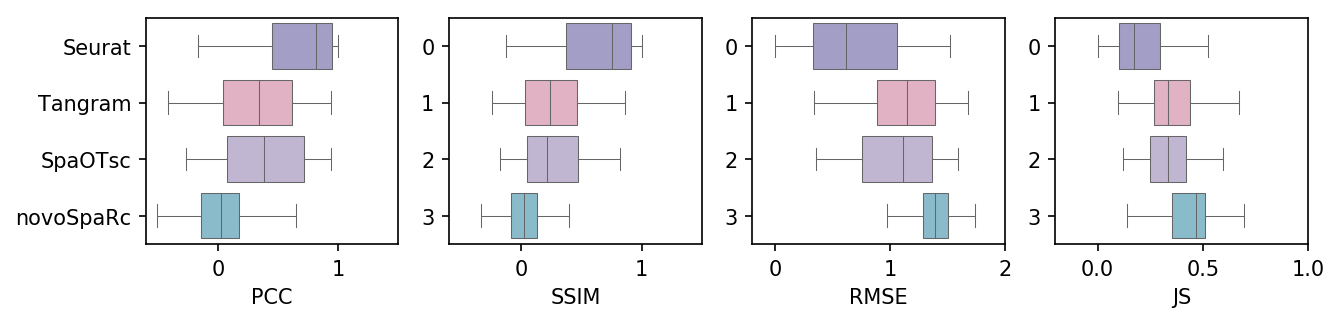

In [176]:
colors=['#9E97CC','#E9A9C2','#BFB1D7','#7EC0D6']
fig, axes = plt.subplots(ncols=4, nrows=1, figsize=(10,2))
Seurat_Metric = pd.read_csv('norm/Seurat_Cellmapping_metric.txt',sep = '\t')
Tangram_Metric = pd.read_csv('norm/Tangram_Cellmapping_metric.txt',sep = '\t')
SpaOTsc_Metric = pd.read_csv('norm/SpaOTsc_Cellmapping_metric.txt',sep = '\t')
novoSpaRc_Metric = pd.read_csv('norm/novoSpaRc_Cellmapping_metric.txt',sep = '\t')

sns.boxplot(data=[np.array(Seurat_Metric['PCC']),np.array(Tangram_Metric['PCC']),np.array(SpaOTsc_Metric['PCC']),np.array(novoSpaRc_Metric['PCC'])],fliersize=0,linewidth=0.5,palette=colors,orient='h',ax=axes[0])
axes[0].set_yticklabels(['Seurat','Tangram','SpaOTsc','novoSpaRc'])
axes[0].set_xlabel('PCC')
axes[0].set_xlim(-0.6,1.5)


sns.boxplot(data=[np.array(Seurat_Metric['SSIM']),np.array(Tangram_Metric['SSIM']),np.array(SpaOTsc_Metric['SSIM']),np.array(novoSpaRc_Metric['SSIM'])],fliersize=0,linewidth=0.5,palette=colors,orient='h',ax=axes[1])
axes[1].set_xlabel('SSIM')
axes[1].set_xlim(-0.6,1.5)


sns.boxplot(data=[np.array(Seurat_Metric['RMSE']),np.array(Tangram_Metric['RMSE']),np.array(SpaOTsc_Metric['RMSE']),np.array(novoSpaRc_Metric['RMSE'])],fliersize=0,linewidth=0.5,palette=colors,orient='h',ax=axes[2])
axes[2].set_xlabel('RMSE')
axes[2].set_xlim(-0.2,2.0)


sns.boxplot(data=[np.array(Seurat_Metric['JS']),np.array(Tangram_Metric['JS']),np.array(SpaOTsc_Metric['JS']),np.array(novoSpaRc_Metric['JS'])],fliersize=0,linewidth=0.5,palette=colors,orient='h',ax=axes[3])
axes[3].set_xlabel('JS')
axes[3].set_xlim(-0.2,1)
plt.savefig('STARmap_norm_compare.pdf')

plt.show()


In [139]:
gd = pd.read_csv('Simulated_seqFISH+/combined_spot_clusters.txt', sep = '\t', index_col=0)
seurat_results = pd.read_csv('Result_seqFISH+/Seurat_alignment.txt', index_col=0)
seurat_results = seurat_results.iloc[:,1:-1]
Cols = seurat_results.columns
used_ind = [(x.split('score.')[1]) for x in Cols]
seurat_results.columns = used_ind
seurat_results.index = np.arange(len(seurat_results))
seurat_results

,Inhibitory,Endo,Other,ExcitatoryL5&6,ExcitatoryL2&3,OtherNeuron,ExcitatoryL4,Olig,Astro,Micro,Smc
0,0.493005,0.031900,0.0,0.274890,0.000000,0.0,0.008498,0.158892,0.032814,0.000000,0
1,0.181367,0.555498,0.0,0.074538,0.000000,0.0,0.014114,0.008929,0.159520,0.006034,0
2,0.029724,0.047044,0.0,0.001579,0.003719,0.0,0.000000,0.139247,0.772468,0.006218,0
3,0.449961,0.100534,0.0,0.084426,0.064763,0.0,0.011239,0.000000,0.220032,0.069045,0
4,0.508044,0.007058,0.0,0.232859,0.053981,0.0,0.051905,0.146152,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...
67,0.011440,0.000000,0.0,0.642890,0.000000,0.0,0.008656,0.336154,0.000000,0.000860,0
68,0.098706,0.024492,0.0,0.065902,0.000000,0.0,0.002165,0.207708,0.600325,0.000703,0
69,0.081788,0.000000,0.0,0.042933,0.000000,0.0,0.003193,0.740464,0.131622,0.000000,0
70,0.201636,0.000000,0.0,0.129042,0.000000,0.0,0.003585,0.660655,0.005082,0.000000,0


In [138]:
gd

,Astro,Endo,Ependymal,ExcitatoryL2&3,ExcitatoryL4,ExcitatoryL5&6,Inhibitory,Micro,NSC,Neuroblast,Neuroblasts,Non-known,OPC,Olig
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,1.0,1.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0
68,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [120]:
seurat_results = pd.read_csv('Result_STARmap/' + '/Seurat_alignment.txt',index_col=0)
seurat_results = seurat_results.iloc[:,1:-1]
Cols = seurat_results.columns
used_ind = [(x.split('score.')[1].replace('.','&')) for x in Cols]
seurat_results.columns = used_ind
seurat_results.index = np.arange(len(seurat_results))
sc_rna_meta = pd.read_csv('STARmap/sc_rna_meta.txt',sep = '\t',index_col=0, header = 0)
gd_result = pd.read_csv('Simulated_STARmap/combined_spot_clusters.txt',sep = '\t',index_col=0, header = 0)
CellType = seurat_results.columns & gd_result.columns
seurat_results = seurat_results[CellType]
seurat_results = (seurat_results.T/seurat_results.sum(axis=1)).T
seurat_results = seurat_results.fillna(0)
seurat_results.to_csv('Result_STARmap/' + '/seurat_CellType_proportion.txt')


Tangram_results = pd.read_csv('Result_STARmap/' + '/Tangram_alignment.txt',index_col=0)
Tangram_results = Tangram_results[CellType]
Tangram_results = (Tangram_results.T/Tangram_results.sum(axis=1)).T
Tangram_results = Tangram_results.fillna(0)
Tangram_results.to_csv('Result_STARmap/' + '/Tangram_CellType_proportion.txt')
    

SpaOTsc_map = np.load('Result_STARmap/SpaOTsc_alignment.npy')
SpaOTsc_results=pd.DataFrame(np.zeros((SpaOTsc_map.shape[1],len(np.unique(sc_rna_meta['celltype'])))),columns=np.unique(sc_rna_meta['celltype']))
for c in np.unique(sc_rna_meta['celltype']):
    SpaOTsc_results.loc[:,c] =  SpaOTsc_map[np.where(sc_rna_meta.celltype == c)[0],:].mean(axis=0)
SpaOTsc_results = SpaOTsc_results[CellType]
SpaOTsc_results = (SpaOTsc_results.T/SpaOTsc_results.sum(axis=1)).T
SpaOTsc_results = SpaOTsc_results.fillna(0)
SpaOTsc_results.to_csv('Result_STARmap/' + '/SpaOTsc_CellType_proportion.txt')

novoSpaRc_map = np.load('Result_STARmap/novoSpaRc_alignment.npy')
novoSpaRc_results=pd.DataFrame(np.zeros((novoSpaRc_map.shape[1],len(np.unique(sc_rna_meta['celltype'])))),columns=np.unique(sc_rna_meta['celltype']))
for c in np.unique(sc_rna_meta['celltype']):
    novoSpaRc_results.loc[:,c] =  novoSpaRc_map[np.where(sc_rna_meta.celltype == c)[0],:].mean(axis=0)
novoSpaRc_results = novoSpaRc_results[CellType]
novoSpaRc_results = (novoSpaRc_results.T/novoSpaRc_results.sum(axis=1)).T
novoSpaRc_results = novoSpaRc_results.fillna(0)
novoSpaRc_results.to_csv('Result_STARmap/' + '/novoSpaRc_CellType_Proportion.txt')  

novoSpaRc_results

,Vip,Sst,Pvalb,Endo,ExcitatoryL6,ExcitatoryL2&3,ExcitatoryL5,ExcitatoryL4,Olig,Astro,Micro,Smc
0,0.066227,0.049661,0.024655,0.015584,0.002884,0.002431,0.004200,0.003673,0.020328,0.022852,0.750855,0.036649
1,0.066246,0.048697,0.024246,0.015777,0.002826,0.002377,0.004127,0.003609,0.021226,0.023657,0.748515,0.038696
2,0.175901,0.138478,0.088692,0.047419,0.011921,0.010636,0.017360,0.015389,0.071587,0.059002,0.267523,0.096092
3,0.199933,0.170625,0.127401,0.064453,0.020911,0.019477,0.029753,0.026915,0.091236,0.072603,0.063816,0.112875
4,0.184940,0.175102,0.144702,0.070223,0.030290,0.028900,0.041421,0.037980,0.089737,0.068591,0.021049,0.107065
...,...,...,...,...,...,...,...,...,...,...,...,...
184,0.027531,0.032625,0.041175,0.112082,0.125065,0.121469,0.112159,0.112555,0.095282,0.111933,0.017440,0.090682
185,0.025148,0.028540,0.034543,0.121270,0.115806,0.108959,0.100591,0.101330,0.098861,0.135046,0.025894,0.104008
186,0.021709,0.024515,0.028461,0.123451,0.103419,0.093514,0.087236,0.089051,0.096876,0.159663,0.060827,0.111277
187,0.016147,0.017402,0.018059,0.102701,0.066296,0.056895,0.054089,0.056146,0.080860,0.161898,0.265880,0.103627


In [5]:
PATH = 'FigureData/Figure4/Dataset4_seqFISH+/'
Seurat_Metric = pd.read_csv(PATH + 'Result_seqFISH+/Seurat_Cellmapping_metric.txt',sep = '\t')
Tangram_Metric = pd.read_csv(PATH + 'Result_seqFISH+/Tangram_Cellmapping_metric.txt',sep = '\t')
SpaOTsc_Metric = pd.read_csv(PATH + 'Result_seqFISH+/SpaOTsc_Cellmapping_metric.txt',sep = '\t')
novoSpaRc_Metric = pd.read_csv(PATH + 'Result_seqFISH+/novoSpaRc_Cellmapping_metric.txt',sep = '\t')
Methods = ['Seurat','Tangram','SpaOTsc','novoSpaRc']
Metrics = ['PCC','SSIM','RMSE','JS']
out = open(PATH + 'Result_seqFISH+/Significant.txt','w')
for L in range(len(Metrics)):
    out.write(Metrics[L] + '\n')
    out.write('\t')
    out.write('\t'.join(Methods))
    out.write('\n')
    out.write('Seurat\t')
    print (Metrics[L])
    P = mannwhitneyu(np.array(Seurat_Metric[Metrics[L]]),np.array(Seurat_Metric[Metrics[L]]))[1]
    out.write(str(P) + '\t')
    P = mannwhitneyu(np.array(Seurat_Metric[Metrics[L]]),np.array(Tangram_Metric[Metrics[L]]))[1]
    out.write(str(P) + '\t')
    P = mannwhitneyu(np.array(Seurat_Metric[Metrics[L]]),np.array(SpaOTsc_Metric[Metrics[L]]))[1]
    out.write(str(P) + '\t')
    P = mannwhitneyu(np.array(Seurat_Metric[Metrics[L]]),np.array(novoSpaRc_Metric[Metrics[L]]))[1]
    out.write(str(P) + '\n')
    
    out.write('Tangram\t')
    P = mannwhitneyu(np.array(Tangram_Metric[Metrics[L]]),np.array(Seurat_Metric[Metrics[L]]))[1]
    out.write(str(P) + '\t')
    P = mannwhitneyu(np.array(Tangram_Metric[Metrics[L]]),np.array(Tangram_Metric[Metrics[L]]))[1]
    out.write(str(P) + '\t')
    P = mannwhitneyu(np.array(Tangram_Metric[Metrics[L]]),np.array(SpaOTsc_Metric[Metrics[L]]))[1]
    out.write(str(P) + '\t')
    P = mannwhitneyu(np.array(Tangram_Metric[Metrics[L]]),np.array(novoSpaRc_Metric[Metrics[L]]))[1]
    out.write(str(P) + '\n')
    
    out.write('SpaOTsc\t')
    P = mannwhitneyu(np.array(SpaOTsc_Metric[Metrics[L]]),np.array(Seurat_Metric[Metrics[L]]))[1]
    out.write(str(P) + '\t')
    P = mannwhitneyu(np.array(SpaOTsc_Metric[Metrics[L]]),np.array(Tangram_Metric[Metrics[L]]))[1]
    out.write(str(P) + '\t')
    P = mannwhitneyu(np.array(SpaOTsc_Metric[Metrics[L]]),np.array(SpaOTsc_Metric[Metrics[L]]))[1]
    out.write(str(P) + '\t')
    P = mannwhitneyu(np.array(SpaOTsc_Metric[Metrics[L]]),np.array(novoSpaRc_Metric[Metrics[L]]))[1]
    out.write(str(P) + '\n')

    out.write('novoSpaRc\t')
    P = mannwhitneyu(np.array(novoSpaRc_Metric[Metrics[L]]),np.array(Seurat_Metric[Metrics[L]]))[1]
    out.write(str(P) + '\t')
    P = mannwhitneyu(np.array(novoSpaRc_Metric[Metrics[L]]),np.array(Tangram_Metric[Metrics[L]]))[1]
    out.write(str(P) + '\t')
    P = mannwhitneyu(np.array(novoSpaRc_Metric[Metrics[L]]),np.array(SpaOTsc_Metric[Metrics[L]]))[1]
    out.write(str(P) + '\t')
    P = mannwhitneyu(np.array(novoSpaRc_Metric[Metrics[L]]),np.array(novoSpaRc_Metric[Metrics[L]]))[1]
    out.write(str(P) + '\n')
    out.write('\n')
    

out.close()


PCC
SSIM
RMSE
JS


14


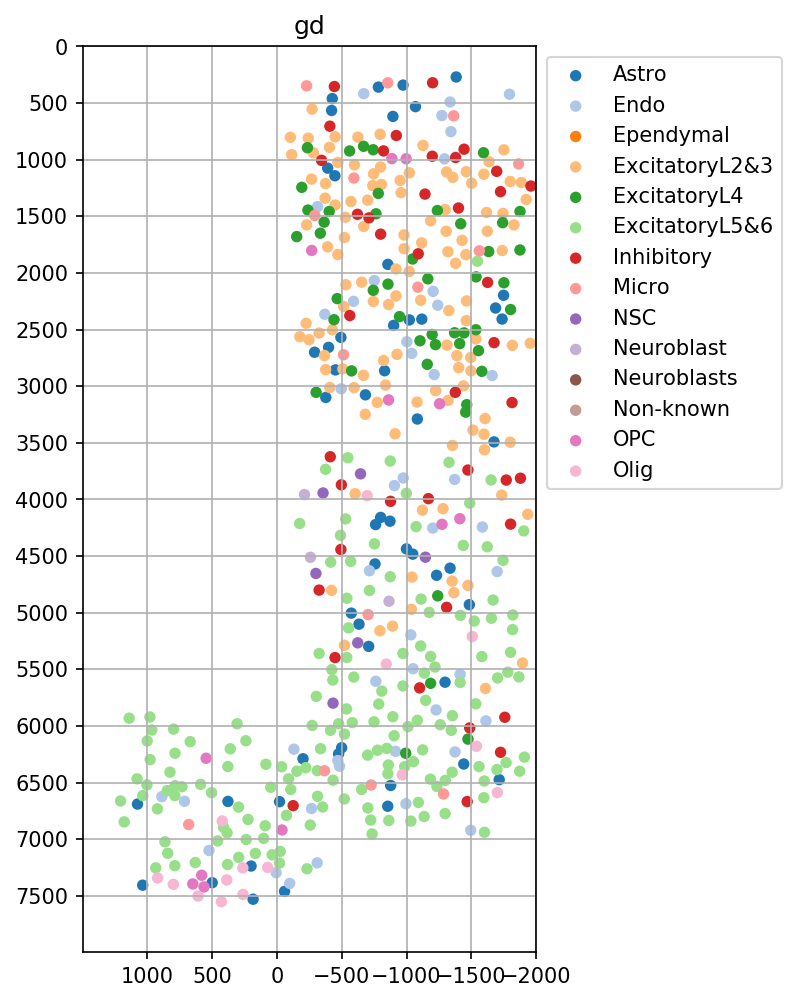

In [165]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['figure.dpi'] = 150
spatial_meta = pd.read_csv('seqFISH+/spatial_meta.txt',sep='\t')
spatial_loc = pd.read_csv('seqFISH+/Locations_seqfish.txt',sep='\t')
fig,ax = plt.subplots(figsize=(3.9,8))
print (len(np.unique(spatial_meta.celltype)))
cmap = sns.color_palette('tab20',n_colors=len(np.unique(np.array(spatial_meta.celltype))))
for i,c in enumerate(np.unique(spatial_meta.celltype)):
    ax.scatter(x=spatial_loc[spatial_meta['celltype'] == c]['Y'][:-1],y=spatial_loc[spatial_meta['celltype'] == c]['X'][:-1],c=matplotlib.colors.to_hex(cmap[i]),label=c,s=30,marker='o',edgecolors='none')
ax.set_title('gd')
ax.legend(bbox_to_anchor=(1,1))
plt.xticks(np.arange(-2000,1500,500))
plt.yticks(np.arange(0,8000,500))
plt.xlim(-2000,1500)
plt.ylim(0,8000)
ax.invert_yaxis()
ax.invert_xaxis()
plt.grid()
plt.savefig('seqFISH_gd.pdf')
plt.show()

In [205]:
pearsonr(seurat_results['Excitatory L4'],gd_results['Excitatory L4'])

(0.45565849151788973, 5.769888507116524e-05)

In [4]:
import seaborn as sns
from sklearn.metrics import mean_squared_error
from scipy.spatial.distance import jensenshannon
from scipy.stats import pearsonr,ttest_ind,mannwhitneyu
%matplotlib inline

def cal_ssim(im1,im2,M=1):
    im1, im2 = im1/im1.max(), im2/im2.max()
    mu1 = im1.mean()
    mu2 = im2.mean()
    sigma1 = np.sqrt(((im1 - mu1) ** 2).mean())
    sigma2 = np.sqrt(((im2 - mu2) ** 2).mean())
    sigma12 = ((im1 - mu1) * (im2 - mu2)).mean()
    k1, k2, L = 0.01, 0.03, M
    C1 = (k1*L) ** 2
    C2 = (k2*L) ** 2
    C3 = C2/2
    l12 = (2*mu1*mu2 + C1)/(mu1 ** 2 + mu2 ** 2 + C1)
    c12 = (2*sigma1*sigma2 + C2)/(sigma1 ** 2 + sigma2 ** 2 + C2)
    s12 = (sigma12 + C3)/(sigma1*sigma2 + C3)
    ssim = l12 * c12 * s12
    return ssim
def rsme(x1,x2):
    x1 = st.zscore(x1)
    x2 = st.zscore(x2)
    return mean_squared_error(x1,x2,squared=False)


def CalculateMetric(outdir,Methods,gd_celltype,gd_loc):
    gd_loc = pd.read_csv(gd_loc,sep='\t')
    data = []
    for Method in Methods:
        gd_results = pd.read_csv(gd_celltype,sep = '\t',index_col=0, header = 0)
        Predict_results = pd.read_csv(outdir + '/' + Method + '_CellType_proportion.txt',sep = ',', header = 0, index_col = 0)
        PCC = []
        SSIM = []
        JS = []
        RMSE = []
        CellTypeUse = Predict_results.columns & gd_results.columns
        Predict_results = Predict_results[CellTypeUse]
        gd_results = gd_results[CellTypeUse]
        gd_results = (gd_results.T/gd_results.sum(axis=1)).T
        gd_results = gd_results.fillna(0)
        print ('We Use Celltype Number ' + str(len(CellTypeUse)))
        for i in range(len(gd_results)):
            if np.max(gd_results.loc[i,:]) == 0 or np.max(Predict_results.loc[i,:]) == 0:
                PCC.append(P[0])
                SSIM.append(P[0])
                RMSE.append(1.5)
                JS.append(1)
            else:
                P = pearsonr(Predict_results.loc[i,:],gd_results.loc[i,:])
                PCC.append(P[0])
                SSIM.append(cal_ssim(Predict_results.loc[i,:],gd_results.loc[i,:]))
                RMSE.append(rsme(Predict_results.loc[i,:],gd_results.loc[i,:]))
                JSD = jensenshannon(Predict_results.loc[i,:],gd_results.loc[i,:])
                JS.append(JSD**2)
        
        PCC = np.nan_to_num(PCC, nan=0)
        SSIM = np.nan_to_num(SSIM, nan=0)
        RMSE = np.nan_to_num(RMSE, nan = 1.5)
        JS = np.nan_to_num(JS, nan=1)
        
        Metric = pd.DataFrame(PCC)
        Metric.columns = ['PCC']
        Metric['SSIM'] = SSIM
        Metric['RMSE'] = RMSE
        Metric['JS'] = JS
        Metric.to_csv(outdir + '/' + Method + '_Cellmapping_metric.txt',sep = '\t')   

#Methods = ['Seurat','Tangram','SpaOTsc','novoSpaRc']
#outdir = 'Result_STARmap/'
#CalculateMetric(outdir,Methods,'Simulated_STARmap/combined_spot_clusters.txt','Simulated_STARmap/combined_Locations.txt')   



PCC mean valuse: 
0.5200895622120051
0.299765548610398
0.558996747424798
0.15375893667148888
SSIM mean valuse: 
0.4803675758756953
0.24684936510597716
0.28008156976435683
0.07152141635642165
RMSE mean valuse: 
0.8576997326219262
1.1262335001309927
0.9200918224358878
1.287629676019658
JS mean valuse: 
0.28932937308863627
0.36960349580909957
0.33724987885017854
0.3977879916184731


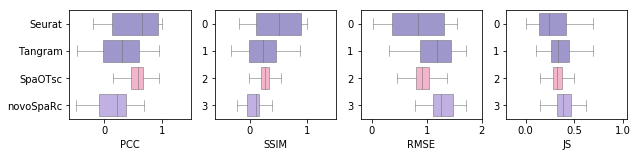

In [5]:
colors=['#7BD2F3','#BDA9EA','#FEAACA','#988ED5','#988ED5']
fig, axes = plt.subplots(ncols=4, nrows=1, figsize=(10,2))
Seurat_Metric = pd.read_csv('Result_STARmap/Seurat_Cellmapping_metric.txt',sep = '\t')
Tangram_Metric = pd.read_csv('Result_STARmap/Tangram_Cellmapping_metric.txt',sep = '\t')
SpaOTsc_Metric = pd.read_csv('Result_STARmap/SpaOTsc_Cellmapping_metric.txt',sep = '\t')
novoSpaRc_Metric = pd.read_csv('Result_STARmap/novoSpaRc_Cellmapping_metric.txt',sep = '\t')

sns.boxplot(data=[np.array(Seurat_Metric['PCC']),np.array(Tangram_Metric['PCC']),np.array(SpaOTsc_Metric['PCC']),np.array(novoSpaRc_Metric['PCC'])],fliersize=0,linewidth=0.5,palette=colors[::-1],orient='h',ax=axes[0])
axes[0].set_yticklabels(['Seurat','Tangram','SpaOTsc','novoSpaRc'])
axes[0].set_xlabel('PCC')
axes[0].set_xlim(-0.6,1.5)

print ('PCC mean valuse: ')
print (Seurat_Metric['PCC'].mean())
print (Tangram_Metric['PCC'].mean())
print (SpaOTsc_Metric['PCC'].mean())
print (novoSpaRc_Metric['PCC'].mean())

sns.boxplot(data=[np.array(Seurat_Metric['SSIM']),np.array(Tangram_Metric['SSIM']),np.array(SpaOTsc_Metric['SSIM']),np.array(novoSpaRc_Metric['SSIM'])],fliersize=0,linewidth=0.5,palette=colors[::-1],orient='h',ax=axes[1])
axes[1].set_xlabel('SSIM')
axes[1].set_xlim(-0.6,1.5)

print ('SSIM mean valuse: ')
print (Seurat_Metric['SSIM'].mean())
print (Tangram_Metric['SSIM'].mean())
print (SpaOTsc_Metric['SSIM'].mean())
print (novoSpaRc_Metric['SSIM'].mean())


sns.boxplot(data=[np.array(Seurat_Metric['RMSE']),np.array(Tangram_Metric['RMSE']),np.array(SpaOTsc_Metric['RMSE']),np.array(novoSpaRc_Metric['RMSE'])],fliersize=0,linewidth=0.5,palette=colors[::-1],orient='h',ax=axes[2])
axes[2].set_xlabel('RMSE')
axes[2].set_xlim(-0.2,2.0)

print ('RMSE mean valuse: ')
print (Seurat_Metric['RMSE'].mean())
print (Tangram_Metric['RMSE'].mean())
print (SpaOTsc_Metric['RMSE'].mean())
print (novoSpaRc_Metric['RMSE'].mean())

sns.boxplot(data=[np.array(Seurat_Metric['JS']),np.array(Tangram_Metric['JS']),np.array(SpaOTsc_Metric['JS']),np.array(novoSpaRc_Metric['JS'])],fliersize=0,linewidth=0.5,palette=colors[::-1],orient='h',ax=axes[3])
axes[3].set_xlabel('JS')
axes[3].set_xlim(-0.2,)

print ('JS mean valuse: ')
print (Seurat_Metric['JS'].mean())
print (Tangram_Metric['JS'].mean())
print (SpaOTsc_Metric['JS'].mean())
print (novoSpaRc_Metric['JS'].mean())
#plt.savefig('Result_STARmap/Boxplt.pdf')

plt.show()


In [100]:
SpaOTsc_Metric['PCC']

0     -0.162441
1      0.215773
2      0.760197
3      0.726876
4      0.562234
         ...   
184    0.443236
185    0.661188
186   -0.418514
187    0.866848
188    0.515147
Name: PCC, Length: 189, dtype: float64

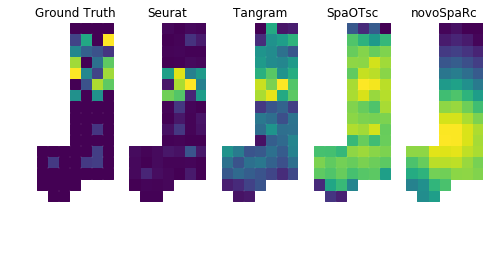

(0.45698735680008373, 5.454518801545631e-05)
(0.5357046079460424, 1.2404699710736095e-06)
(0.27730362422997806, 0.01836032676950579)
(-0.455824638952778, 5.7295542791903065e-05)


In [6]:
PATH = 'FigureData/Figure4/Dataset4_seqFISH+/'
seurat_results = pd.read_csv(PATH + 'Result_seqFISH+/Seurat_CellType_proportion.txt',sep = ',', header = 0, index_col = 0)
tangram_results = pd.read_csv(PATH + 'Result_seqFISH+/Tangram_CellType_proportion.txt',sep = ',', header = 0, index_col = 0)
spa_results = pd.read_csv(PATH + 'Result_seqFISH+/SpaOTsc_CellType_proportion.txt',sep = ',', header = 0, index_col = 0)
novo_results = pd.read_csv(PATH + 'Result_seqFISH+/novoSpaRc_CellType_proportion.txt',sep = ',', header = 0, index_col = 0)

gd_results = pd.read_csv(PATH + 'Simulated_seqFISH+/combined_spot_clusters.txt',sep = '\t',index_col=0, header = 0)
gd_results = (gd_results.T/gd_results.sum(axis=1)).T
gd_results = gd_results.fillna(0)
gd_loc = pd.read_csv(PATH + 'Simulated_seqFISH+/combined_Locations.txt',sep='\t')
C = 'ExcitatoryL4'
fig,axes = plt.subplots(ncols=5,nrows=1,figsize=(8,3.9))
axes[0].scatter(y=gd_loc['x'][:-1],x=gd_loc['y'][:-1],c=gd_results[C][:-1],s=105,marker='s')
# axes[0].scatter(x=5,y=18,c=0,s=500,marker='s')
axes[0].set_ylim(-0.5,18.5)
axes[0].set_xlim(-4.5,2.5)
axes[0].invert_yaxis()
axes[0].invert_xaxis()
axes[0].axis('off')
axes[0].set_title('Ground Truth')
axes[1].scatter(y=gd_loc['x'][:-1],x=gd_loc['y'][:-1],c=seurat_results[C][:-1],s=105,marker='s')
# axes[1].scatter(x=5,y=18,c=0,s=500,marker='s',)
axes[1].set_ylim(-0.5,18.5)
axes[1].set_xlim(-4.5,2.5)
axes[1].invert_yaxis()
axes[1].invert_xaxis()
axes[1].axis('off')
axes[1].set_title('Seurat')
axes[2].scatter(y=gd_loc['x'][:-1],x=gd_loc['y'][:-1],c=tangram_results[C][:-1],s=105,marker='s')
# axes[2].scatter(x=5,y=18,c=0,s=500,marker='s',)
axes[2].set_ylim(-0.5,18.5)
axes[2].set_xlim(-4.5,2.5)
axes[2].invert_yaxis()
axes[2].invert_xaxis()
axes[2].axis('off')
axes[2].set_title('Tangram')
axes[3].scatter(y=gd_loc['x'][:-1],x=gd_loc['y'][:-1],c=spa_results[C][:-1],s=105,marker='s')
# axes[3].scatter(x=5,y=18,c=0,s=500,marker='s',)
axes[3].set_ylim(-0.5,18.5)
axes[3].set_xlim(-4.5,2.5)
axes[3].invert_yaxis()
axes[3].invert_xaxis()
axes[3].axis('off')
axes[3].set_title('SpaOTsc')
axes[4].scatter(y=gd_loc['x'][:-1],x=gd_loc['y'][:-1],c=novo_results[C][:-1],s=105,marker='s')
# axes[4].scatter(x=5,y=18,c=0,s=500,marker='s',)
axes[4].set_ylim(-0.5,18.5)
axes[4].set_xlim(-4.5,2.5)
axes[4].invert_yaxis()
axes[4].invert_xaxis()
axes[4].axis('off')
axes[4].set_title('novoSpaRc')
# plt.savefig('seqfish_eL4_distribution.pdf',bbox_inches='tight',dpi=300)
#plt.savefig('seqfish_eL23_distribution.pdf')
plt.show()

print (pearsonr(seurat_results[C],gd_results[C]))
print (pearsonr(tangram_results[C],gd_results[C]))
print (pearsonr(spa_results[C],gd_results[C]))
print (pearsonr(novo_results[C],gd_results[C]))



In [106]:
gd_results

,Astro,Endo,Ependymal,ExcitatoryL2&3,ExcitatoryL4,ExcitatoryL5&6,Inhibitory,Micro,NSC,Neuroblast,Neuroblasts,Non-known,OPC,Olig
0,0.000000,1.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00,0.000000
1,0.333333,0.333333,0.0,0.0,0.0,0.000000,0.333333,0.000000,0.0,0.0,0.0,0.0,0.00,0.000000
2,0.500000,0.250000,0.0,0.0,0.0,0.000000,0.000000,0.250000,0.0,0.0,0.0,0.0,0.00,0.000000
3,0.333333,0.000000,0.0,0.0,0.0,0.000000,0.333333,0.333333,0.0,0.0,0.0,0.0,0.00,0.000000
4,0.000000,0.000000,0.0,0.5,0.5,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,0.083333,0.083333,0.0,0.0,0.0,0.416667,0.000000,0.000000,0.0,0.0,0.0,0.0,0.25,0.166667
68,1.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00,0.000000
69,0.500000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00,0.500000
70,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00,1.000000


In [144]:
gd_results = pd.read_csv('Simulated_seqFISH+/combined_spot_clusters.txt',sep = '\t',index_col=0, header = 0)
gd_results

,Astro,Endo,Ependymal,ExcitatoryL2&3,ExcitatoryL4,ExcitatoryL5&6,Inhibitory,Micro,NA,NSC,Neuroblast,Neuroblasts,OPC,Olig
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,1.0,1.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0
68,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [165]:
seurat_results = pd.read_csv('Result_STARmap/Seurat_CellType_proportion.txt',sep = ',', header = 0, index_col = 0)
tangram_results = pd.read_csv('Result_STARmap/Tangram_CellType_proportion.txt',sep = ',', header = 0, index_col = 0)
spa_results = pd.read_csv('Result_STARmap/SpaOTsc_CellType_proportion.txt',sep = ',', header = 0, index_col = 0)
novo_results = pd.read_csv('Result_STARmap/novoSpaRc_CellType_proportion.txt',sep = ',', header = 0, index_col = 0)

gd_results = pd.read_csv('Simulated_STARmap/combined_spot_clusters.txt',sep = '\t',index_col=0, header = 0)
gd_results = (gd_results.T/gd_results.sum(axis=1)).T
gd_results = gd_results.fillna(0)
gd_loc = pd.read_csv('Simulated_STARmap/combined_Locations.txt',sep='\t')
C = 'ExcitatoryL6'
fig,axes = plt.subplots(ncols=5,nrows=1,figsize=(8,3.9))
axes[0].scatter(x=gd_loc['x'],y=gd_loc['y'],c=gd_results[C],s=105,marker='s')
#axes[0].scatter(x=5,y=18,c=0,s=500,marker='s')
#axes[0].set_ylim(-0.5,18.5)
#axes[0].set_xlim(-4.5,2.5)
axes[0].invert_yaxis()
axes[0].invert_xaxis()
axes[0].axis('off')
axes[0].set_title('Ground Truth')
axes[1].scatter(x=gd_loc['x'],y=gd_loc['y'],c=seurat_results[C],s=105,marker='s')
# axes[1].scatter(x=5,y=18,c=0,s=500,marker='s',)
#axes[1].set_ylim(-0.5,18.5)
#axes[1].set_xlim(-4.5,2.5)
axes[1].invert_yaxis()
axes[1].invert_xaxis()
axes[1].axis('off')
axes[1].set_title('Seurat')
axes[2].scatter(x=gd_loc['x'],y=gd_loc['y'],c=tangram_results[C],s=105,marker='s')
# axes[2].scatter(x=5,y=18,c=0,s=500,marker='s',)
#axes[2].set_ylim(-0.5,18.5)
#axes[2].set_xlim(-4.5,2.5)
axes[2].invert_yaxis()
axes[2].invert_xaxis()
axes[2].axis('off')
axes[2].set_title('Tangram')
axes[3].scatter(x=gd_loc['x'],y=gd_loc['y'],c=spa_results[C],s=105,marker='s')
# axes[3].scatter(x=5,y=18,c=0,s=500,marker='s',)
#axes[3].set_ylim(-0.5,18.5)
#axes[3].set_xlim(-4.5,2.5)
axes[3].invert_yaxis()
axes[3].invert_xaxis()
axes[3].axis('off')
axes[3].set_title('SpaOTsc')
axes[4].scatter(x=gd_loc['x'],y=gd_loc['y'],c=novo_results[C],s=105,marker='s')
# axes[4].scatter(x=5,y=18,c=0,s=500,marker='s',)
#axes[4].set_ylim(-0.5,18.5)
#axes[4].set_xlim(-4.5,2.5)
axes[4].invert_yaxis()
axes[4].invert_xaxis()
axes[4].axis('off')
axes[4].set_title('novoSpaRc')
# plt.savefig('seqfish_eL4_distribution.pdf',bbox_inches='tight',dpi=300)
#plt.savefig('seqfish_eL23_distribution.png',bbox_inches='tight',dpi=300)
plt.show()

print (pearsonr(seurat_results[C],gd_results[C]))
print (pearsonr(tangram_results[C],gd_results[C]))
print (pearsonr(spa_results[C],gd_results[C]))
print (pearsonr(novo_results[C],gd_results[C]))

FileNotFoundError: [Errno 2] No such file or directory: 'Result_STARmap/Seurat_CellType_proportion.txt'

Text(0.5, 1.0, 'Ground Truth')

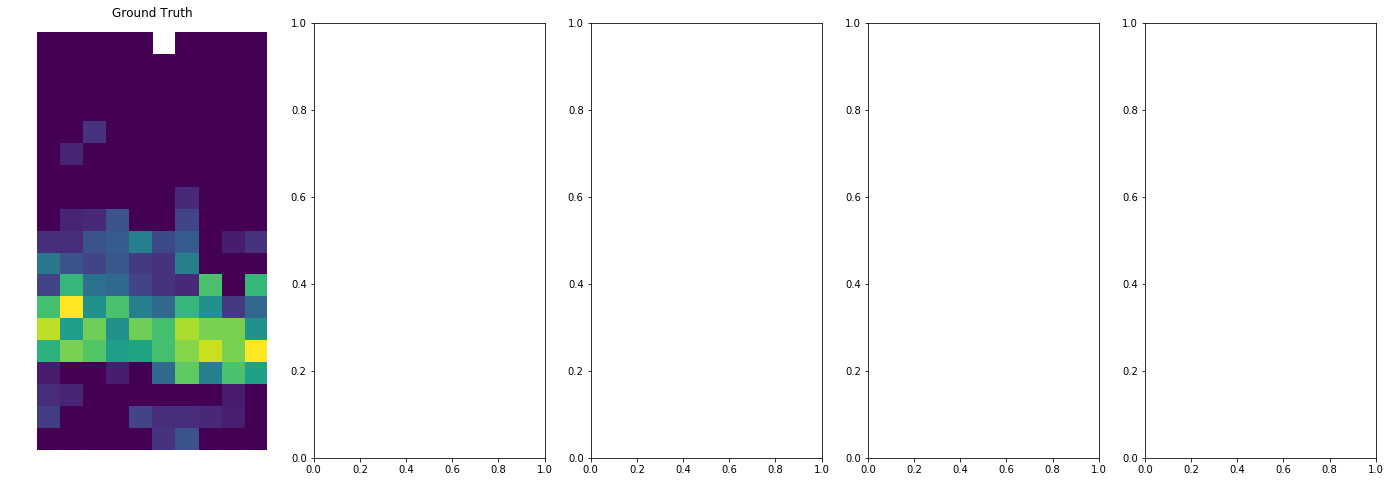

In [206]:
gd_results = pd.read_csv('Simulated_STARmap/combined_spot_clusters.txt',sep = '\t',index_col=0, header = 0)
gd_results = (gd_results.T/gd_results.sum(axis=1)).T
gd_results = gd_results.fillna(0)
gd_loc = pd.read_csv('Simulated_STARmap/combined_Locations.txt',sep='\t')
C = 'ExcitatoryL6'
fig,axes = plt.subplots(ncols=5,nrows=1,figsize=(24,8))
axes[0].scatter(x=gd_loc['x'],y=gd_loc['y'],c=gd_results[C],s=500,marker='s')
# axes[0].scatter(x=5,y=18,c=0,s=500,marker='s')
#axes[0].set_ylim(-0.5,18.5)
#axes[0].set_xlim(-4.5,2.5)
#axes[0].invert_yaxis()
#axes[0].invert_xaxis()
axes[0].axis('off')
axes[0].set_title('Ground Truth')

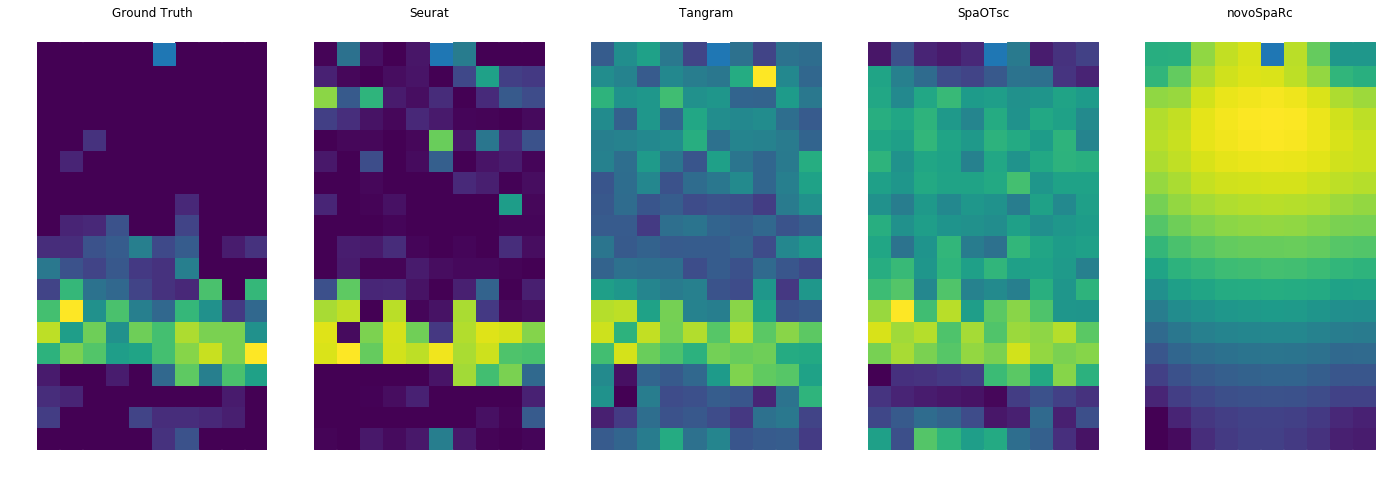

(0.7459621369704491, 7.571291025311179e-35)
(0.6574204801144606, 9.157457175572615e-25)
(0.6169178230195476, 3.3240542567547037e-21)
(-0.36646022422382585, 2.1471186049219954e-07)


In [44]:
import seaborn as sns
from sklearn.metrics import mean_squared_error
from scipy.spatial.distance import jensenshannon
from scipy.stats import pearsonr,ttest_ind,mannwhitneyu
%matplotlib inline
seurat_results = pd.read_csv(PATH + 'Result_STARmap/Seurat_CellType_proportion.txt',sep = ',', header = 0, index_col = 0)
tangram_results = pd.read_csv(PATH + 'Result_STARmap/Tangram_CellType_proportion.txt',sep = ',', header = 0, index_col = 0)
spa_results = pd.read_csv(PATH + 'Result_STARmap/SpaOTsc_CellType_proportion.txt',sep = ',', header = 0, index_col = 0)
novo_results = pd.read_csv(PATH + 'Result_STARmap/novoSpaRc_CellType_proportion.txt',sep = ',', header = 0, index_col = 0)

gd_results = pd.read_csv(PATH + 'Simulated_STARmap/combined_spot_clusters.txt',sep = '\t',index_col=0, header = 0)
gd_results = (gd_results.T/gd_results.sum(axis=1)).T
gd_results = gd_results.fillna(0)
gd_loc = pd.read_csv(PATH + 'Simulated_STARmap/combined_Locations.txt',sep='\t')
C = 'ExcitatoryL6'

fig,axes = plt.subplots(ncols=5,nrows=1,figsize=(24,8))
axes[0].scatter(x=gd_loc['x'],y=gd_loc['y'],c=gd_results[C],s=500,marker='s')
axes[0].scatter(x=5,y=18,s=500,marker='s')
#axes[0].invert_yaxis()
#axes[0].invert_xaxis()
axes[0].axis('off')
axes[0].set_title('Ground Truth')

axes[1].scatter(x=gd_loc['x'],y=gd_loc['y'],c=seurat_results[C],s=500,marker='s')
axes[1].scatter(x=5,y=18,s=500,marker='s')
#axes[1].invert_yaxis()
#axes[1].invert_xaxis()
axes[1].axis('off')
axes[1].set_title('Seurat')

axes[2].scatter(x=gd_loc['x'],y=gd_loc['y'],c=tangram_results[C],s=500,marker='s')
axes[2].scatter(x=5,y=18,s=500,marker='s')
#axes[2].invert_yaxis()
#axes[2].invert_xaxis()
axes[2].axis('off')
axes[2].set_title('Tangram')

axes[3].scatter(x=gd_loc['x'],y=gd_loc['y'],c=spa_results[C],s=500,marker='s')
axes[3].scatter(x=5,y=18,s=500,marker='s')
#axes[3].invert_yaxis()
#axes[3].invert_xaxis()
axes[3].axis('off')
axes[3].set_title('SpaOTsc')

axes[4].scatter(x=gd_loc['x'],y=gd_loc['y'],c=novo_results[C],s=500,marker='s')
axes[4].scatter(x=5,y=18,s=500,marker='s')
#axes[4].invert_yaxis()
#axes[4].invert_xaxis()
axes[4].axis('off')
axes[4].set_title('novoSpaRc')
plt.show()


print (pearsonr(seurat_results[C],gd_results[C]))
print (pearsonr(tangram_results[C],gd_results[C]))
print (pearsonr(spa_results[C],gd_results[C]))
print (pearsonr(novo_results[C],gd_results[C]))


In [10]:
PATH = '/Users/wenzhang/Desktop/SpatialBenchmarking/FigureData/Figure2/'
Methods = ['gimVI','SpaGE','Tangram','Seurat','SpaOTsc','LIGER','novoSpaRc']
D = {'Embryo':'Dataset1','osmFISH':'Dataset2','seqFISH-':'Dataset3','seqFISH':'Dataset4',
     'merFISH_adj':'Dataset5','merFISH+':'Dataset6','Starmap_VISP':'Dataset7','Starmap_PFC':'Dataset8',
     'ST':'Dataset9','ST_hipp':'Dataset10','Visium_VISP':'Dataset11','Visium_D2':'Dataset12',
     'Visium_D7':'Dataset13','Slide-seq2_new':'Dataset14',}
for M in Methods:
    for Data in D:
        #os.popen('mv ' + PATH + M + '/' + Data + ' ' + PATH + M + '/' + D[Data])
        F = PATH + M + '/' + D[Data] + '/Result_Zscore.txt'
        if os.path.isfile(F):
            os.popen('mv ' + F + ' ' + PATH + M + '/' + D[Data] + '/metrics.txt')
        else:
            print (F)

/Users/wenzhang/Desktop/SpatialBenchmarking/FigureData/Figure2/gimVI/Dataset3/Result_Zscore.txt
/Users/wenzhang/Desktop/SpatialBenchmarking/FigureData/Figure2/Tangram/Dataset14/Result_Zscore.txt


In [13]:
PATH = '/Users/wenzhang/Desktop/SpatialBenchmarking/FigureData/Figure2/'
Methods = ['gimVI','SpaGE','Tangram','Seurat','SpaOTsc','LIGER','novoSpaRc']
D = {'Embryo':'Dataset1','osmFISH':'Dataset2','seqFISH-':'Dataset3','seqFISH':'Dataset4',
     'merFISH_adj':'Dataset5','merFISH+':'Dataset6','Starmap_VISP':'Dataset7','Starmap_PFC':'Dataset8',
     'ST':'Dataset9','ST_hipp':'Dataset10','Visium_VISP':'Dataset11','Visium_D2':'Dataset12',
     'Visium_D7':'Dataset13','Slide-seq2_new':'Dataset14',}
for M in Methods:
    for Data in D:
        F = PATH + M + '/' + D[Data] + '/metrics.txt'
        if os.path.isfile(F):
            df = pd.read_table(F,index_col = 0)
            df.columns = ['PCC','SSIM','JS','RMSE']
            df.to_csv(F,sep = '\t')
        else:
            print (F)

/Users/wenzhang/Desktop/SpatialBenchmarking/FigureData/Figure2/gimVI/Dataset3/metrics.txt
/Users/wenzhang/Desktop/SpatialBenchmarking/FigureData/Figure2/Tangram/Dataset14/metrics.txt


In [12]:
df

,Unnamed: 0,Pearson,SSIM,KL,RMSE
0,ems,0.442090,0.318941,0.414935,1.056323
1,CG14427,-0.281246,-0.076154,0.181000,1.600779
2,Mdr49,0.736431,0.604744,0.196767,0.726042
3,E(spl)m5-HLH,0.418080,0.246321,0.432484,1.078814
4,ImpL2,0.273374,0.112486,0.144453,1.205509
...,...,...,...,...,...
79,NetA,0.801260,0.612982,0.184322,0.630460
80,brk,0.551373,0.270710,0.154505,0.947235
81,bun,0.288177,0.152981,0.387408,1.193167
82,rho,0.498549,0.250259,0.256421,1.001450
